# Differential abundance between responder and non-responder lesions
***
Jan T. Schleicher, 2022

In this notebook, we use scCODA and Wilcoxon rank-sum tests as benchmark methods to detect differentially abundant cell types between melanoma responder and non-responder lesions. This analysis is based on the data from [Sade-Feldman et al. 2018](https://doi.org/10.1016/j.cell.2018.10.038).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import anndata as ad
import pickle as pkl
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

%config Completer.use_jedi = False
%matplotlib inline

In [3]:
out_dir = "../output/differential_abundance"
os.makedirs(out_dir, exist_ok=True)

## Loading data

We load the data in the form of a scanpy object which we created from the Seurat object. From this, we create the covariates data frame and compositional AnnData object required for scCODA.

In [4]:
# read data
adata = ad.read_h5ad("../data/melanoma_seurat.h5ad")

# create covariates dataframe
cov_df = pd.DataFrame({"Sample": adata.obs.sample_name, "Cond": adata.obs.response_status})\
    .drop_duplicates(subset="Sample")\
    .set_index("Sample")
cov_df.Cond = pd.Categorical(cov_df.Cond, categories=["R", "NR"], ordered=True)

# create compositional data from scanpy data
comp_data = dat.from_scanpy(adata,
                            cell_type_identifier="cluster",
                            sample_identifier="sample_name",
                            covariate_df=cov_df)
comp_data.write(os.path.join(out_dir, "melanoma_sccoda.h5ad"))

/home/ubuntu/miniconda3/envs/sccoda/lib/python3.8/site-packages/sccoda/util/cell_composition_data.py:256: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(X=count_data.values,


## scCODA

We set up the scCODA model for compositional analysis from the compositional data, using automatic reference cell type detection. Then, we run MCMC and look at the results, setting the estimated false discovery rate to 0.1.

In [5]:
# model setup and inference
model = mod.CompositionalAnalysis(comp_data, formula="Cond", reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to 6
Zero counts encountered in data! Added a pseudocount of 0.5.


In [6]:
# run MCMC
sim_results = model.sample_hmc()

100%|████████████████████████████████████| 20000/20000 [01:59<00:00, 168.02it/s]


MCMC sampling finished. (151.622 sec)
Acceptance rate: 58.0%


In [7]:
sim_results.save(os.path.join(out_dir, "melanoma_sccoda_results.pkl"))
sim_results.set_fdr(est_fdr=0.1)
sim_results.summary()

Compositional Analysis summary:

Data: 42 samples, 11 cell types
Reference index: 6
Formula: Cond

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
0                   -0.191        40.943199
1                   -1.210        14.778682
2                   -0.698        24.660079
3                   -1.067        17.050606
4                   -0.237        39.102473
5                   -0.655        25.743591
6                    0.036        51.376749
7                   -0.158        42.316866
8                   -0.567        28.111696
9                   -0.009        49.116043
10                  -0.732        23.835730


Effects:
                      Final Parameter  Expected Sample  log2-fold change
Covariate  Cell Type                                                    
Cond[T.NR] 0                -0.772828        17.498119         -1.226424
           1                 0.000000        13.679821         -0.111468
           2  

We extract the credible effects from the simulation results and create a data frame containing the cell type proportions, required for plotting.

In [8]:
credible_effects = sim_results.credible_effects()
sccoda_relevant_indices = np.where(credible_effects)[0]
cell_types = credible_effects.index.get_level_values(1).to_list()

prop_df = pd.DataFrame(comp_data.X/np.sum(comp_data.X, axis=1, keepdims=True),
                       columns=comp_data.var.index, index=comp_data.obs.index)\
    .merge(comp_data.obs.Cond, left_index=True, right_index=True)\
    .melt(id_vars="Cond", var_name="cell type", value_name="proportion")

## Wilcoxon rank-sum tests

As another basic method, we use Wilcoxon rank-sum tests to identify differentially abundant cell types between the two conditions.

In [9]:
# perform testing for cluster frequencies
meta_data = pd.read_csv("../data/melanoma_umap.txt", sep="\t", index_col=0)
cell_type_frequencies = meta_data.groupby(["response_status", "sample_name"], observed=True)["cluster"]\
    .value_counts(normalize=True).rename("frequency").unstack(fill_value=0).reset_index()\
    .melt(id_vars=["response_status", "sample_name"], value_name="frequency")
cell_type_frequencies

,response_status,sample_name,cluster,frequency
0,NR,Post_P10,G1,0.002525
1,NR,Post_P11,G1,0.003195
2,NR,Post_P12,G1,0.000000
3,NR,Post_P13,G1,0.253898
4,NR,Post_P14,G1,0.057751
...,...,...,...,...
457,R,Pre_P26,G9,0.006006
458,R,Pre_P28,G9,0.026706
459,R,Pre_P33,G9,0.002212
460,R,Pre_P7,G9,0.073370


In [10]:
clusters = ["G" + str(i) for i in range(1, 12)]
differential_abundance_dict = {"cluster_index": [], "cluster": [], "log2fc": [], "p": []}

for i, c in enumerate(clusters):
    df = cell_type_frequencies[cell_type_frequencies.cluster == c]
    # Wilcoxon test
    _, p = stats.ranksums(*df.groupby('response_status')['frequency'].apply(lambda x: x.values))
    differential_abundance_dict["cluster_index"].append(i)
    differential_abundance_dict["cluster"].append(c)
    differential_abundance_dict["p"].append(p)
    # log2fc
    differential_abundance_dict["log2fc"].append(np.log2(df.loc[df.response_status == "NR", "frequency"].mean() /
                                                         df.loc[df.response_status == "R", "frequency"].mean()))
    
differential_abundance = pd.DataFrame(differential_abundance_dict)
differential_abundance["padj"] = multipletests(differential_abundance.p, method="fdr_bh")[1]

significant_indices = differential_abundance.loc[differential_abundance.padj < 0.1, "cluster_index"]

differential_abundance.to_csv(os.path.join(out_dir, "melanoma_differential_abundance_wilcoxon.csv"))
differential_abundance

,cluster_index,cluster,log2fc,p,padj
0,0,G1,-2.158012,0.002407,0.013238
1,1,G2,0.578780,0.780688,0.780688
2,2,G3,2.065498,0.010422,0.028662
3,3,G4,1.278635,0.089436,0.157844
4,4,G5,-1.032665,0.100446,0.157844
5,5,G6,1.962359,0.005844,0.021429
6,6,G7,0.252103,0.290052,0.398822
7,7,G8,0.480612,0.372954,0.455833
8,8,G9,0.283632,0.635986,0.699584
9,9,G10,-1.860139,0.042104,0.092629


## Plotting of results

Finally, we create grouped boxplots to show the results of scCODA and the Wilcoxon rank-sum tests.

In [11]:
from matplotlib.lines import Line2D
sns.set_theme(style="ticks", font_scale=1)

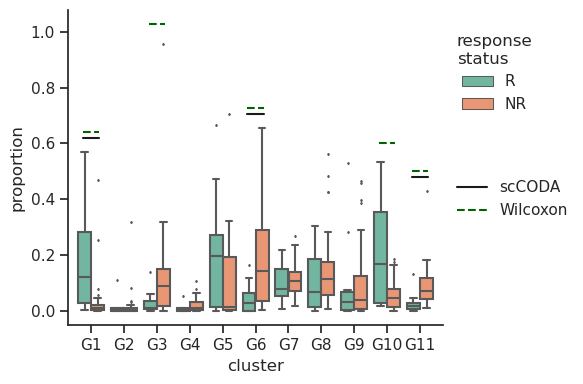

In [12]:
# grouped boxplots
ax = viz.boxplots(comp_data, feature_name="Cond", plot_facets=False,
                  y_scale="relative", add_dots=False, figsize=(6,4),
                  cmap="Set2")
ax.set_xticks(range(0, 11), labels=clusters, rotation=0)


# add annotations for sccoda credible effects
for i in sccoda_relevant_indices:
    x_min = i - .25
    x_max = i + .25
    y = np.max(prop_df.loc[prop_df["cell type"] == cell_types[i], "proportion"] + .05)
    ax.plot([x_min, x_max], [y, y], linewidth=1.5, c="k")

# add annotations for Wilcoxon rank sum test significant differences
for i in significant_indices:
    x_min = i - .25
    x_max = i + .25
    y = np.max(prop_df.loc[prop_df["cell type"] == cell_types[i], "proportion"] + .07)
    ax.plot([x_min, x_max], [y, y], linewidth=1.5, c="darkgreen", linestyle="--")

ax.set_xlabel("cluster")
ax.set_ylabel("proportion")
legend_1 = ax.legend(loc="center left", title="response\nstatus", frameon=False, bbox_to_anchor=(1,.8))
custom_lines = [Line2D([0], [0], color="k", lw=1.5),
                Line2D([0], [0], color="darkgreen", ls="--", lw=1.5)]
ax.legend(custom_lines, ["scCODA", "Wilcoxon"], loc="center left", frameon=False, bbox_to_anchor=(1,.4))
ax.add_artist(legend_1)
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "melanoma_cluster_frequencies.svg"))
plt.show()